# Preprocessing

In [1]:
import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib_venn import venn2
from matplotlib_venn import venn3, venn3_circles
import seaborn as sns
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Load initial data
df_mut = pd.read_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/raw/TCGA.BRCA.mutations.txt', sep='\t')
initial_count = len(df_mut)
print(f"Initial rows loaded: {initial_count:,}")

# --- Step 1: Filter 'PASS' ---
count_before = len(df_mut)

df_mut = df_mut[df_mut['FILTER'] == 'PASS'] # exclude samples the didn't pass QC

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (FILTER != 'PASS'). Remaining: {count_after:,}")


# --- Step 2: Filter 'SNP' ---
count_before = len(df_mut)

df_mut = df_mut[df_mut['Variant_Type'] == 'SNP'] # exclude indels

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (Variant_Type != 'SNP'). Remaining: {count_after:,}")


# --- Step 3: Calculate 'mutation_type' ---
print("Determining synonymous or nonsynonymous mutations...")
df_mut.loc[:,'mutation_type'] = df_mut.apply(lambda row: 'synonymous' if row['Variant_Classification'] == 'Silent' else 'non-synonymous' if row['CDS_position'] != '.' else None, axis=1)


# --- Step 4: Drop rows where 'mutation_type' is None ---
print("Filtering out mutations not in CDS...")
count_before = len(df_mut)

df_mut = df_mut.dropna(subset=['mutation_type']) # Drop rows that have None (or NaN) in the 'mutation_type' column

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (mutation_type is None). Remaining: {count_after:,}")


# --- Step 5: Filter Hugo_Symbol NA ---
count_before = len(df_mut)

df_mut = df_mut[df_mut['Hugo_Symbol'].notna()] # remove genes that don't have a symbol

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (Hugo_Symbol is NA). Remaining: {count_after:,}")


# --- Step 6: Filter Start_Position NA ---
count_before = len(df_mut)

df_mut = df_mut[df_mut['Start_Position'].notna()] # remove rows without a position

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows (Start_Position is NA). Remaining: {count_after:,}")


# --- Step 7: Filter Hypermutators ---
print("Filtering hypermutator samples (>500 mutations/patient)...")

mutation_counts = df_mut['patient_id'].value_counts() # count mutations per patient

# Identify patients with <= 500 mutations
hypermutator_threshold = 500
normal_mutators = mutation_counts[mutation_counts <= hypermutator_threshold].index
hypermutator_patients = mutation_counts[mutation_counts > hypermutator_threshold].index
print(f" -> Identified {len(hypermutator_patients):,} hypermutator patients.")

count_before = len(df_mut)

df_mut = df_mut[df_mut['patient_id'].isin(normal_mutators)] # filter out hypermutators

count_after = len(df_mut)
print(f"Filtered out {count_before - count_after:,} rows belonging to hypermutators. Remaining: {count_after:,}")


# --- Final Count ---
print(f"\nFinal number of rows after all filters: {len(df_mut):,}")

Initial rows loaded: 134,947
Filtered out 42,911 rows (FILTER != 'PASS'). Remaining: 92,036
Filtered out 11,044 rows (Variant_Type != 'SNP'). Remaining: 80,992
Determining synonymous or nonsynonymous mutations...
Filtering out mutations not in CDS...
Filtered out 14,512 rows (mutation_type is None). Remaining: 66,480
Filtered out 0 rows (Hugo_Symbol is NA). Remaining: 66,480
Filtered out 0 rows (Start_Position is NA). Remaining: 66,480
Filtering hypermutator samples (>500 mutations/patient)...
 -> Identified 16 hypermutator patients.
Filtered out 18,484 rows belonging to hypermutators. Remaining: 47,996

Final number of rows after all filters: 47,996


In [3]:
df_mut

patient_id Hugo_Symbol  Entrez_Gene_Id Center NCBI_Build Chromosome  \
3       TCGA-3C-AAAU       CD248               0      .     GRCh37         11   
7       TCGA-3C-AAAU      MIPOL1               0      .     GRCh37         14   
8       TCGA-3C-AAAU       THSD4               0      .     GRCh37         15   
9       TCGA-3C-AAAU        ULK3               0      .     GRCh37         15   
10      TCGA-3C-AAAU     CACNA1H               0      .     GRCh37         16   
...              ...         ...             ...    ...        ...        ...   
134937  TCGA-Z7-A8R6       KCNT1               0      .     GRCh37          9   
134938  TCGA-Z7-A8R6       RABL6               0      .     GRCh37          9   
134940  TCGA-Z7-A8R6        PGM5               0      .     GRCh37          9   
134942  TCGA-Z7-A8R6        IPPK               0      .     GRCh37          9   
134943  TCGA-Z7-A8R6       STAG2               0      .     GRCh37          X   

        Start_Position  End_Position Strand Variant_Classification  ...  \
3             66082467      66082467      +      Missense_Mutation  ...   
7             37838785      37838785      +      Missense_Mutation  ...   
8             72039337      72039337      +      Missense_Mutation  ...   
9             75130677      75130677      +                 Silent  ...   
10             1260133       1260133      +                 Silent  ...   
...                ...           ...    ...                    ...  ...   
134937       138660705     138660705      +      Missense_Mutation  ...   
134938       139732034     139732034      +      Missense_Mutation  ...   
134940        70993158      70993158      +      Missense_Mutation  ...   
134942        95396703      95396703      +      Missense_Mutation  ...   
134943       123217344     123217344      +      Missense_Mutation  ...   

                        PolyPhen  \
3                  benign(0.001)   
7                  benign(0.002)   
8                  benign(0.444)   
9                              .   
10                             .   
...                          ...   
134937   probably_damaging(0.97)   
134938             benign(0.002)   
134940      probably_damaging(1)   
134942  probably_damaging(0.968)   
134943      probably_damaging(1)   

                                                  DOMAINS    IMPACT  \
3       Low_complexity_(Seg):seg,hmmpanther:PTHR24838:...  MODERATE   
7         Coiled-coils_(Ncoils):Coil,hmmpanther:PTHR22089  MODERATE   
8       PROSITE_profiles:PS50092,hmmpanther:PTHR13723,...  MODERATE   
9       Low_complexity_(Seg):seg,hmmpanther:PTHR24348,...       LOW   
10        hmmpanther:PTHR10037,hmmpanther:PTHR10037:SF192       LOW   
...                                                   ...       ...   
134937  Gene3D:3.40.50.720,hmmpanther:PTHR10027,hmmpan...  MODERATE   
134938      Low_complexity_(Seg):seg,hmmpanther:PTHR14932  MODERATE   
134940  hmmpanther:PTHR22573,hmmpanther:PTHR22573:SF27...  MODERATE   
134942           hmmpanther:PTHR14456,Pfam_domain:PF06090  MODERATE   
134943      hmmpanther:PTHR11199,hmmpanther:PTHR11199:SF3  MODERATE   

       VARIANT_CLASS FILTER COSMIC                                   CALLERS  \
3                SNV   PASS   NONE                           MUTECT|VARSCANS   
7                SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
8                SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
9                SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
10               SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
...              ...    ...    ...                                       ...   
134937           SNV   PASS   NONE  MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS   
134938           SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
134940           SNV   PASS   NONE  MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS   
134942           SNV   PASS   NONE                

In [4]:
df_mut.to_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/TCGA.BRCA.mutations.qc1.txt', header=True, index=False, sep='\t')

In [5]:
df_mut = pd.read_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/TCGA.BRCA.mutations.qc1.txt', sep='\t')
df_mut

patient_id Hugo_Symbol  Entrez_Gene_Id Center NCBI_Build Chromosome  \
0      TCGA-3C-AAAU       CD248               0      .     GRCh37         11   
1      TCGA-3C-AAAU      MIPOL1               0      .     GRCh37         14   
2      TCGA-3C-AAAU       THSD4               0      .     GRCh37         15   
3      TCGA-3C-AAAU        ULK3               0      .     GRCh37         15   
4      TCGA-3C-AAAU     CACNA1H               0      .     GRCh37         16   
...             ...         ...             ...    ...        ...        ...   
47991  TCGA-Z7-A8R6       KCNT1               0      .     GRCh37          9   
47992  TCGA-Z7-A8R6       RABL6               0      .     GRCh37          9   
47993  TCGA-Z7-A8R6        PGM5               0      .     GRCh37          9   
47994  TCGA-Z7-A8R6        IPPK               0      .     GRCh37          9   
47995  TCGA-Z7-A8R6       STAG2               0      .     GRCh37          X   

       Start_Position  End_Position Strand Variant_Classification  ...  \
0            66082467      66082467      +      Missense_Mutation  ...   
1            37838785      37838785      +      Missense_Mutation  ...   
2            72039337      72039337      +      Missense_Mutation  ...   
3            75130677      75130677      +                 Silent  ...   
4             1260133       1260133      +                 Silent  ...   
...               ...           ...    ...                    ...  ...   
47991       138660705     138660705      +      Missense_Mutation  ...   
47992       139732034     139732034      +      Missense_Mutation  ...   
47993        70993158      70993158      +      Missense_Mutation  ...   
47994        95396703      95396703      +      Missense_Mutation  ...   
47995       123217344     123217344      +      Missense_Mutation  ...   

                       PolyPhen  \
0                 benign(0.001)   
1                 benign(0.002)   
2                 benign(0.444)   
3                             .   
4                             .   
...                         ...   
47991   probably_damaging(0.97)   
47992             benign(0.002)   
47993      probably_damaging(1)   
47994  probably_damaging(0.968)   
47995      probably_damaging(1)   

                                                 DOMAINS    IMPACT  \
0      Low_complexity_(Seg):seg,hmmpanther:PTHR24838:...  MODERATE   
1        Coiled-coils_(Ncoils):Coil,hmmpanther:PTHR22089  MODERATE   
2      PROSITE_profiles:PS50092,hmmpanther:PTHR13723,...  MODERATE   
3      Low_complexity_(Seg):seg,hmmpanther:PTHR24348,...       LOW   
4        hmmpanther:PTHR10037,hmmpanther:PTHR10037:SF192       LOW   
...                                                  ...       ...   
47991  Gene3D:3.40.50.720,hmmpanther:PTHR10027,hmmpan...  MODERATE   
47992      Low_complexity_(Seg):seg,hmmpanther:PTHR14932  MODERATE   
47993  hmmpanther:PTHR22573,hmmpanther:PTHR22573:SF27...  MODERATE   
47994           hmmpanther:PTHR14456,Pfam_domain:PF06090  MODERATE   
47995      hmmpanther:PTHR11199,hmmpanther:PTHR11199:SF3  MODERATE   

      VARIANT_CLASS FILTER COSMIC                                   CALLERS  \
0               SNV   PASS   NONE                           MUTECT|VARSCANS   
1               SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
2               SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
3               SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
4               SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
...             ...    ...    ...                                       ...   
47991           SNV   PASS   NONE  MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS   
47992           SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
47993           SNV   PASS   NONE  MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS   
47994           SNV   PASS   NONE                RADIA|MUTECT|MUSE|VARSCANS   
47995           SNV   PASS  

In [6]:
df_mut[df_mut["Hugo_Symbol"] == "FAT3"]["Transcript_ID"].unique() # check if there are multiple transcripts for the same gene

array(['ENST00000298047'], dtype=object)

# Top 20 Most Mutated Genes by Raw Count

In [7]:
# --- Ensure df_mut DataFrame is loaded and processed correctly before this point ---
# Must contain 'Hugo_Symbol', 'mutation_type', and 'Variant_Classification'

print("Preparing data for stacked bar plot with detailed non-synonymous breakdown...")

# 1. Create a unified classification column
df_mut['mutation_class'] = df_mut.apply(
    lambda x: x['Variant_Classification']
              if x['mutation_type'] == 'non-synonymous'
              else 'synonymous',
    axis=1
)

# 2. Define the desired categories and their plot order
syn_col = 'synonymous'
non_syn_classes = [
    "Missense_Mutation",
    "Nonsense_Mutation",
    "Translation_Start_Site",
    "Nonstop_Mutation",
] #  and Nonstop_Mutation don't have recurrently mutated genes
all_classes = [syn_col] + non_syn_classes

# 3. Group and pivot to get counts per gene per class
mutation_counts = df_mut.groupby(['Hugo_Symbol', 'mutation_class']).size()
counts_df = mutation_counts.unstack(fill_value=0)
counts_df

Preparing data for stacked bar plot with detailed non-synonymous breakdown...


mutation_class  Missense_Mutation  Nonsense_Mutation  Nonstop_Mutation  \
Hugo_Symbol                                                              
A1BG                            2                  0                 0   
A1CF                            2                  0                 0   
A2M                             4                  2                 0   
A2ML1                           6                  1                 0   
A4GALT                          0                  1                 0   
...                           ...                ...               ...   
ZYG11B                          0                  0                 0   
ZYX                             1                  0                 0   
ZZEF1                           4                  0                 0   
ZZZ3                            2                  0                 0   
hsa-mir-1199                    0                  0                 0   

mutation_class  Translation_Start_Site  synonymous  
Hugo_Symbol                                         
A1BG                                 0           0  
A1CF                                 0           1  
A2M                                  0           1  
A2ML1                                0           4  
A4GALT                               0           0  
...                                ...         ...  
ZYG11B                               0           1  
ZYX                                  0           1  
ZZEF1                                0           1  
ZZZ3                                 0           0  
hsa-mir-1199                         0           1  

[14559 rows x 5 columns]

/var/folders/jk/ltpq08_128l0byf2mw4yytv40000gn/T/ipykernel_82268/2493191698.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_df['TotalMutations'] = counts_df.sum(axis=1)


PIK3CA, TP53, TTN, MUC16, KMT2C, RYR2, SYNE1, FLG, OBSCN, HMCN1, SPTA1, RYR3, ZFHX4, DMD, USH2A, NEB, CDH1, MAP3K1, MUC5B, CSMD3, CSMD2, LRP1B, AHNAK, MUC4, WDFY4, MUC17, SYNE2, MXRA5, CSMD1, DNAH9, CACNA1E, FAT3, TENM1, PKHD1L1, CUBN, APOB, NCOR1, ABCA13, LRP2, RYR1, LAMA1, DNAH5, AKT1, HYDIN, PCLO, PTEN
Generating stacked bar plot for top 46 genes...


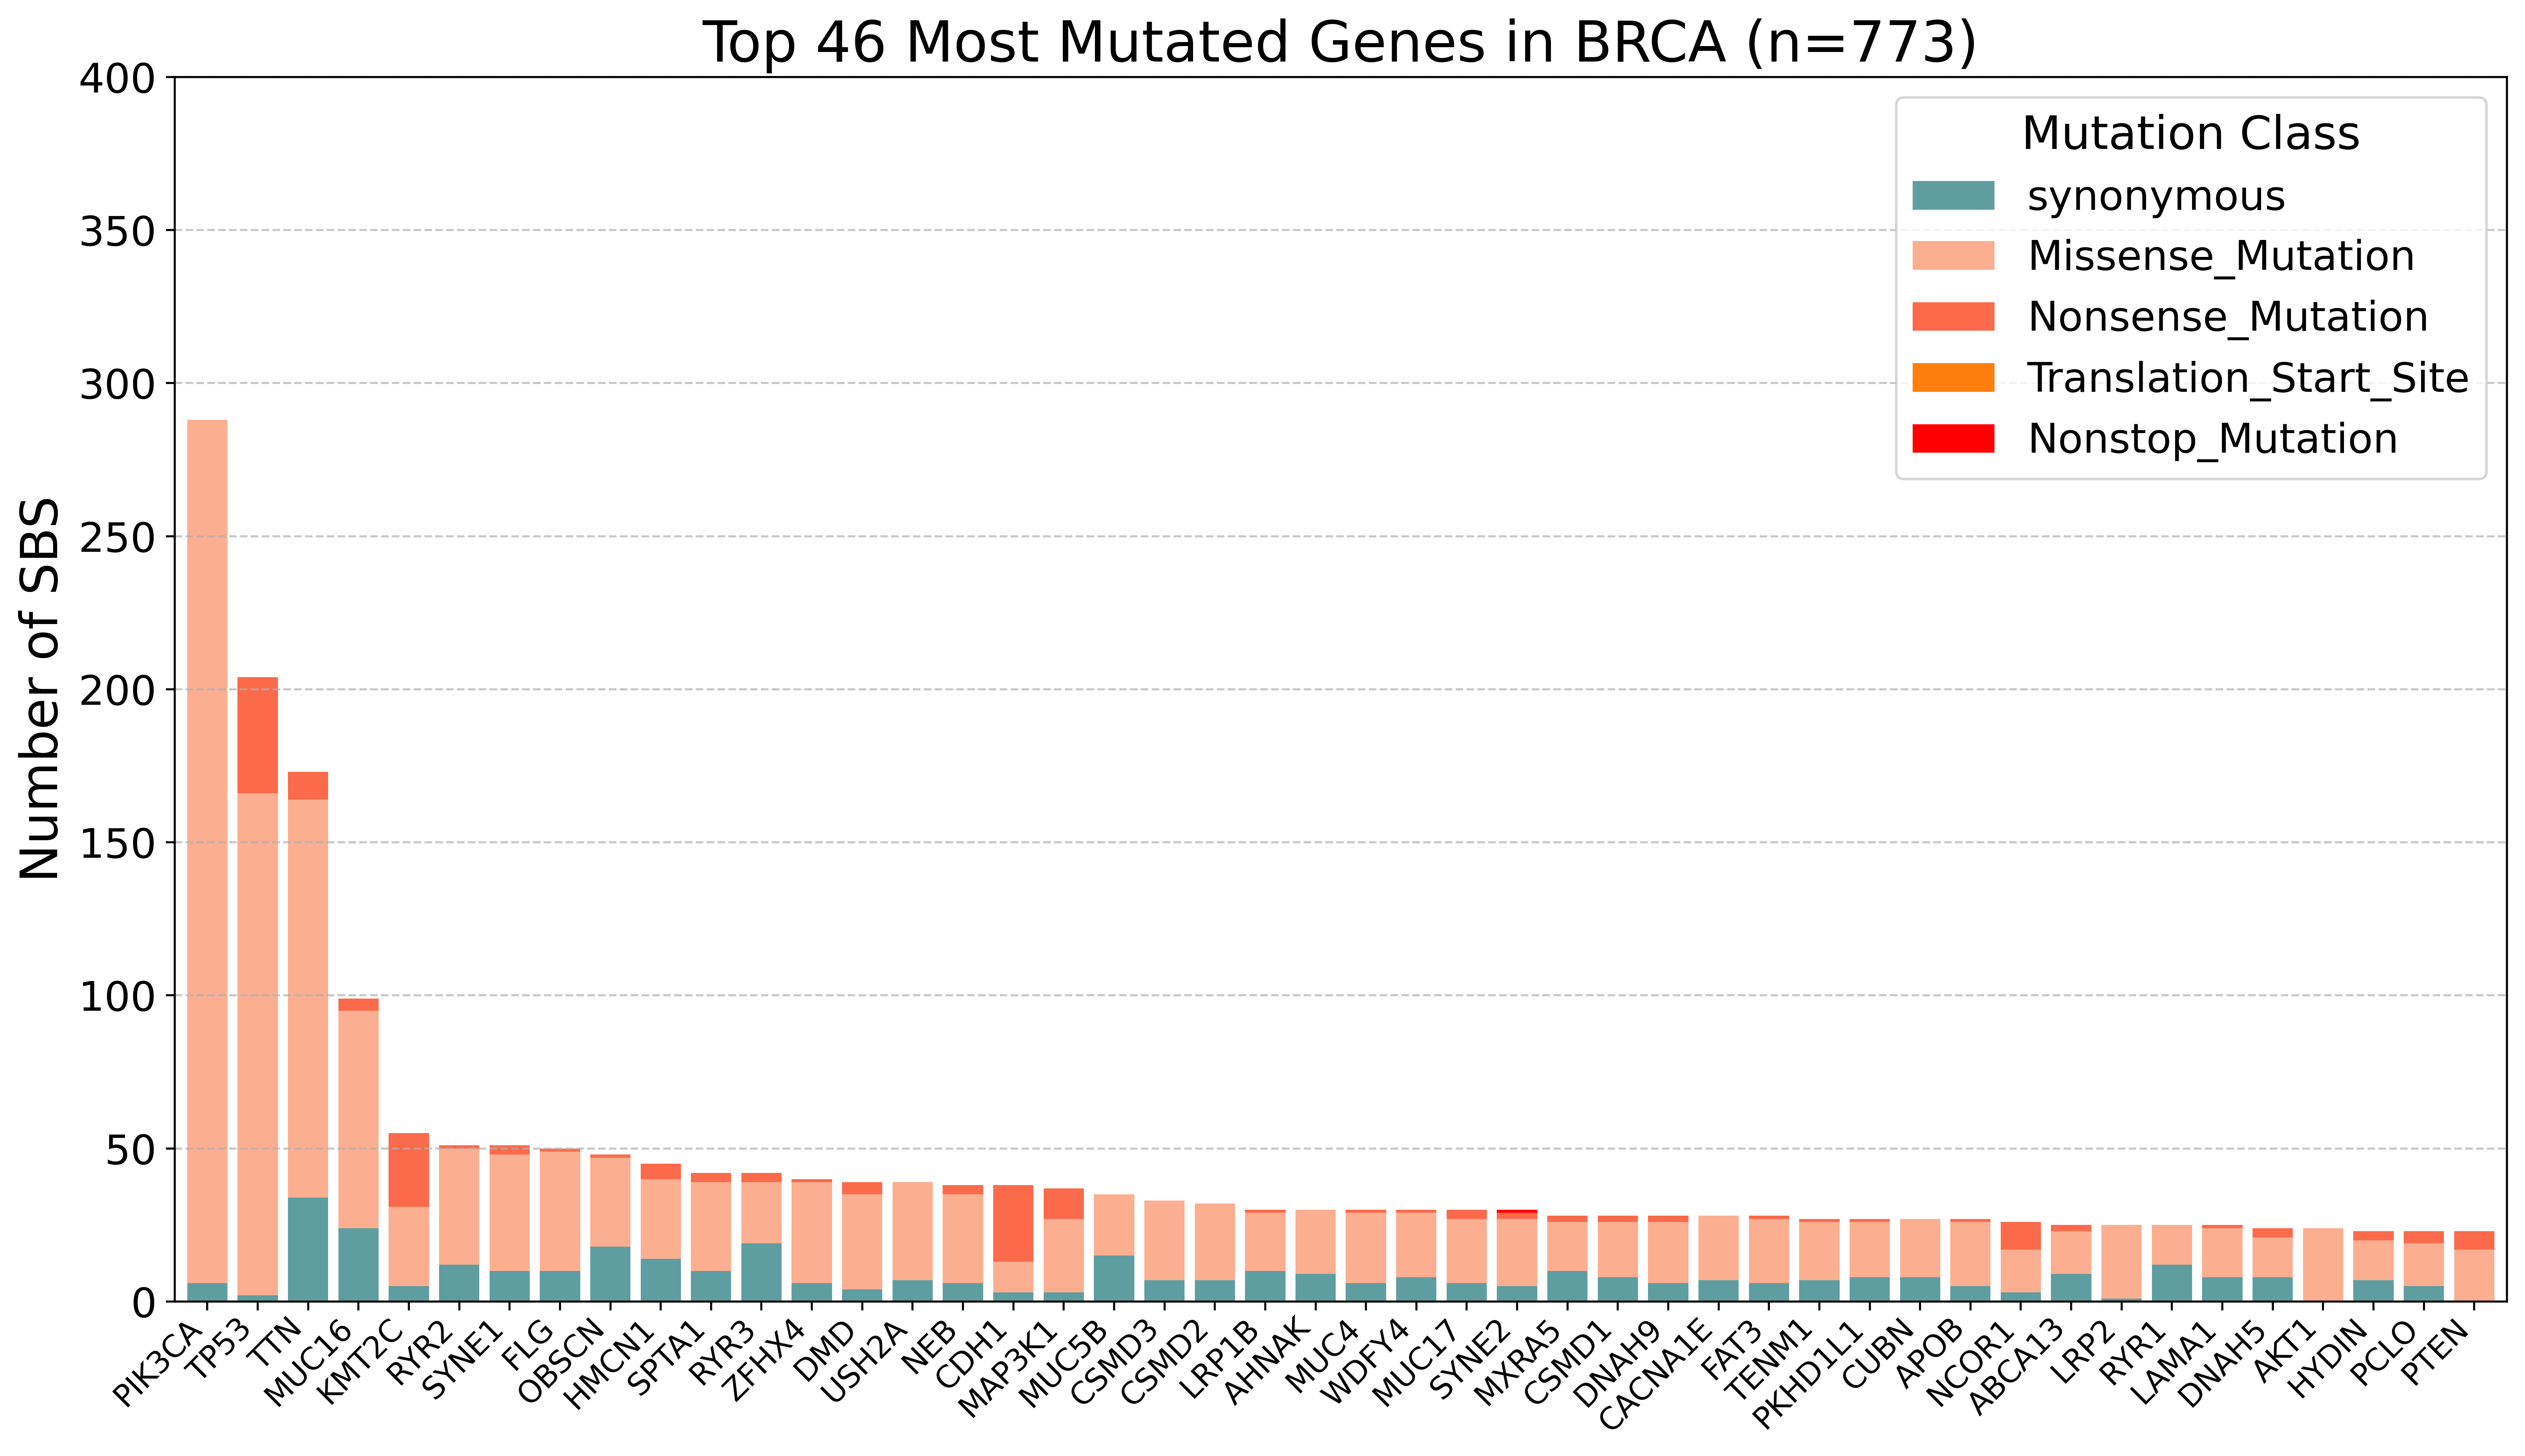

In [8]:
# 4. Ensure all columns exist
for col in all_classes:
    if col not in counts_df.columns:
        counts_df[col] = 0

# 5. Reorder columns
counts_df = counts_df[all_classes]

# 6. Optional: select top N genes by total mutations
counts_df['TotalMutations'] = counts_df.sum(axis=1)
N = 46
top_n = counts_df.sort_values('TotalMutations', ascending=False).head(N)
plot_df = top_n.drop(columns='TotalMutations')
top_46_genes_raw_count = list(plot_df.index)

# 7. Define a color palette: one blue for synonymous, shades of red for non-synonymous
palette = [
    'cadetblue',      # synonymous
    '#fcae91',        # Missense_Mutation (light red) 
    '#fb6a4a',        # Nonsense_Mutation
    "tab:orange",  # Translation_Start_Site
    "red",  # Nonstop_Mutation
]

# 8. Plot
if plot_df.empty:
    print("No data available to plot.")
else:
    print(", ".join(top_46_genes_raw_count))
    print(f"Generating stacked bar plot for top {(len(set(top_46_genes_raw_count)))} genes...")
    fig, ax = plt.subplots(
        figsize=(max(10, len(plot_df) * 0.3), 8),
        dpi=500
    )

    # Plot on this axis
    plot_df.plot(
        kind='bar',
        stacked=True,
        width=0.8,
        color=palette,
        ax=ax
    )

    # Labels and styling
    ax.set_title(f'Top {N} Most Mutated Genes in BRCA (n=773)', fontsize=22)
    ax.set_xlabel('', fontsize=18)
    ax.set_ylabel('Number of SBS', fontsize=20)
    ax.set_xticklabels(plot_df.index, rotation=45, fontsize=12, ha='right')
    ax.tick_params(axis='x', which='major', pad=1)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(title='Mutation Class', fontsize=16, title_fontsize=18)
    ax.grid(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, 400)

    plt.tight_layout()

    # Save at high resolution
    fig.savefig(
        "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/results/figures/Most_mutated_genes_detailed.pdf",
        format="pdf",
        bbox_inches="tight",
        dpi=500
    )

    plt.show()

# Compare to [IntOGen](https://www.intogen.org/search?cohort=TCGA_WXS_BRCA) BRCA TCGA WES from 1009 samples

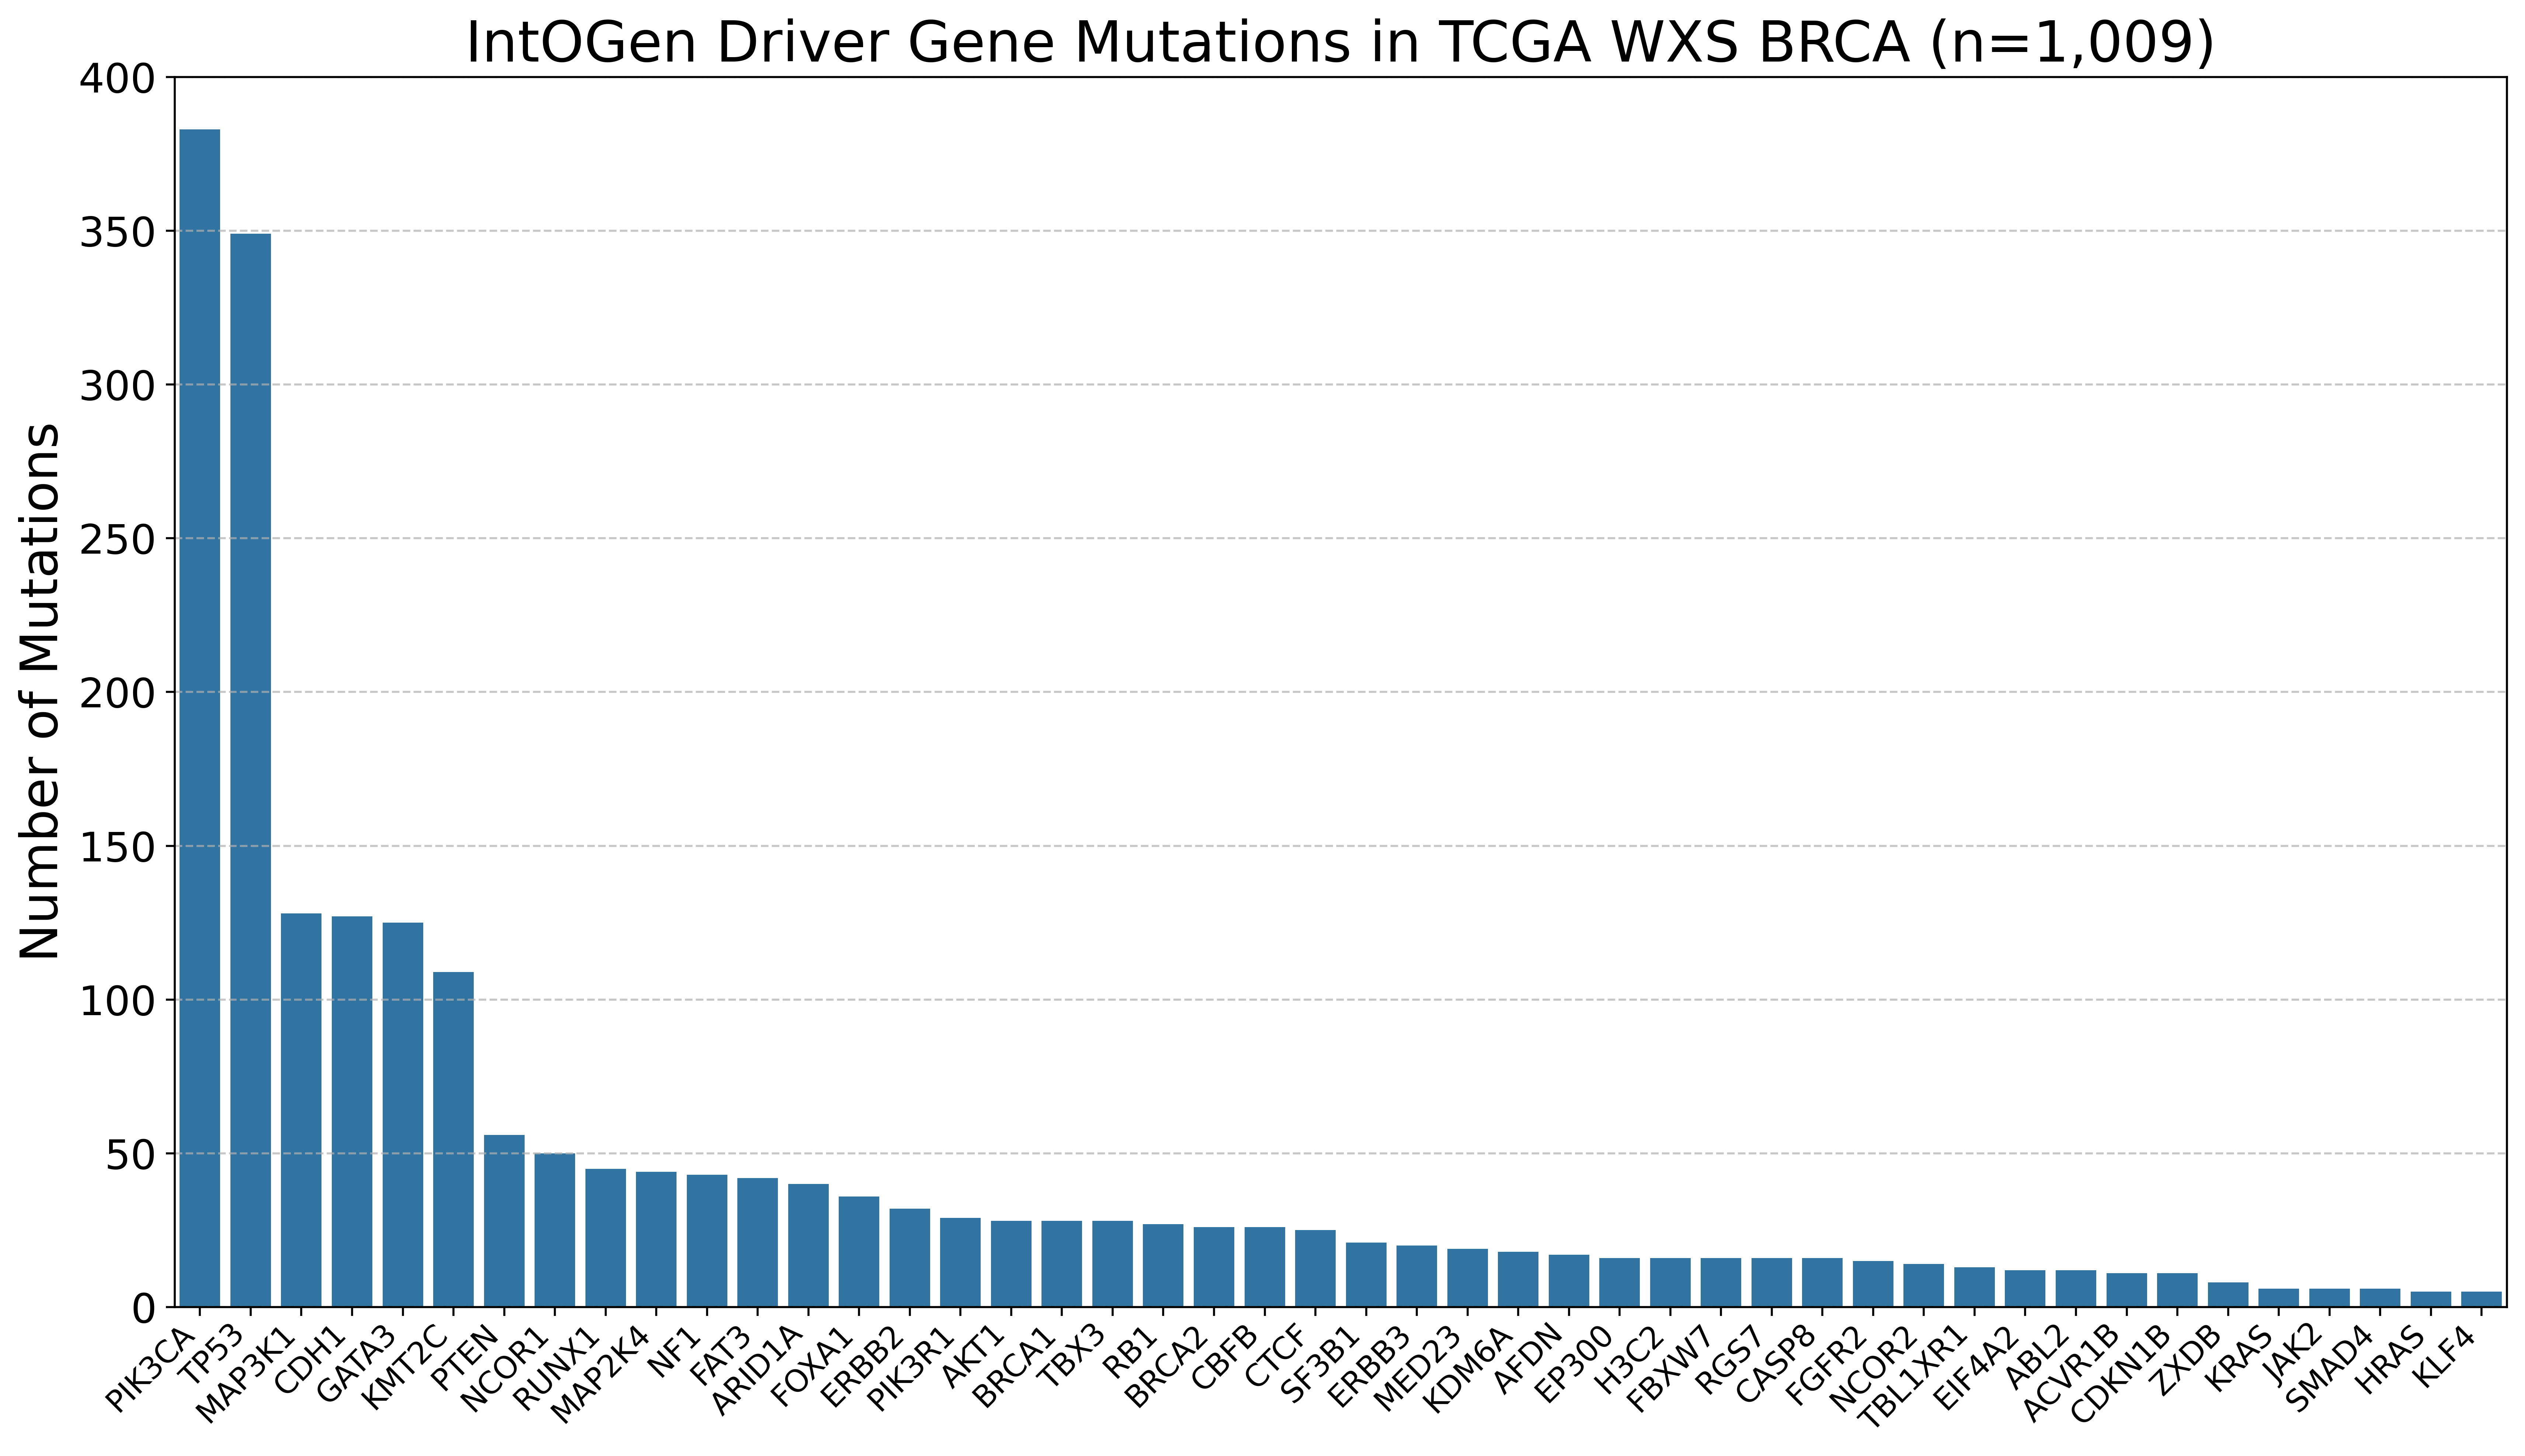

In [ ]:
# 1. Load IntOGen data
IntOGen = '/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/IntOGen-DriverGenes_TCGA_WXS_BRCA.csv'
df_intogen = pd.read_csv(IntOGen, dtype={'Symbol': str, 'Mutations': int})
intogen_genes = list(df_intogen.index)

# 2. Sort by number of mutations (descending)
df_intogen_sorted = df_intogen.sort_values('Mutations', ascending=False)

# Create figure and axis with desired settings
fig, ax = plt.subplots(
    figsize=(max(10, len(df_intogen_sorted) * 0.3), 8),
    dpi=500
)

# Plot barplot
sns.barplot(
    data=df_intogen_sorted,
    x='Symbol',
    y='Mutations',
    color='tab:blue',
    ax=ax
)

# Apply copied settings
ax.set_title('IntOGen Driver Gene Mutations in TCGA WXS BRCA (n=1,009)', fontsize=22)

ax.set_ylabel('Number of Mutations', fontsize=20)
ax.set_ylim(0, 400)
ax.grid(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_xlabel('', fontsize=18)
ax.set_xticklabels(df_intogen_sorted['Symbol'], rotation=45, fontsize=12, ha='right')
ax.tick_params(axis='x', which='major', pad=1)
ax.tick_params(axis='y', labelsize=16)


plt.tight_layout()

# Save and show
output_path = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/results/figures/IntOGen_DriverGenes_BRCA_Mutations.pdf"
fig.savefig(output_path, format="pdf", bbox_inches="tight", dpi=500)
plt.show()

# Make CDS sequence and length table using Gencode fasta
Use MAF Transcript_ID to find CDS sequence and length (one gene might have 2+ transcripts). If not in .fa file, use Hugo_Symbol and take the longest CDS (1 gene might have 2+ transcripts)

In [10]:


# --- Paths ---
tsv_path  = Path("/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/TCGA.BRCA.mutations.qc1.txt")
fasta_in  = Path("/Users/zichenjiang/Downloads/gencode.v23lift37.pc_transcripts.fa")
fasta_out = Path("/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.fa")
csv_out   = Path("/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.cds_length_sequence.tsv")

# 1. Load TSV and mapping
tsv = pd.read_csv(tsv_path, sep="\t", dtype=str)
mapping = dict(zip(tsv["Transcript_ID"], tsv["Hugo_Symbol"]))
ids      = set(mapping)

# 2. Parse FASTA into dict: transcript_id -> (header still containing separator "|", entire transcript sequence)
transcripts = {}
with fasta_in.open() as f:
    header = None; seq_chunks = []
    for line in f:
        line = line.rstrip("\n")
        if line.startswith(">"):
            if header:
                full_id = header[1:].split("|")[0]
                base_id = full_id.split(".")[0]
                transcripts[base_id] = (header, "".join(seq_chunks))
            header = line; seq_chunks = []
        else:
            seq_chunks.append(line)
    if header:
        full_id = header[1:].split("|")[0]
        base_id = full_id.split(".")[0]
        transcripts[base_id] = (header, "".join(seq_chunks))
transcripts

{'ENST00000335137': ('>ENST00000335137.3|ENSG00000186092.4|OTTHUMG00000001094.1|OTTHUMT00000003223.1|OR4F5-001|OR4F5|918|CDS:1-918|',
  'ATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGCTCACATTACAGTAGTTCTTTTGTTCTTTGGACCATGTGTCTTTATTTATGCCTGGCCATTCCCCATCAAGTCATTAGATAAATTCCTTGCTGTATTTTATTCTGTGATCACCCCTCTCTTGAACCCAATTATATACACACTGAGGAACAAAGACATGAA

In [11]:
results = []
with fasta_out.open("w") as fout:
    for tx_id in ids:
        gene = mapping[tx_id]
        entry = transcripts.get(tx_id)

        # if exact transcript not found, fallback to any transcripts matching gene
        if entry is None:
            print(f"Warning: {tx_id} not found. Falling back on Hugo_Symbol {gene}.")
            candidates = []
            for bid, (hdr, seq) in transcripts.items():
                # match gene field in header: |GENE|
                if f"|{gene}|" in hdr:
                    m = re.search(r"CDS:(\d+)-(\d+)", hdr)
                    if m:
                        start, end = map(int, m.groups())
                        cds_len = end - start + 1
                        candidates.append((bid, hdr, seq, start, end, cds_len))
            if not candidates:
                print(f"Warning: No fallback transcripts for gene {gene}.")
                continue
            # pick the one with longest CDS
            candidates.sort(key=lambda x: x[5], reverse=True)
            chosen = candidates[0]
            print(f"  Fallback candidates:")
            for bid, hdr, seq, st, en, clen in candidates:
                print(f"    {bid}: CDS:{st}-{en} (len={clen:,})")
            print(f"  Chosen: {chosen[0]} with CDS:{chosen[3]}-{chosen[4]} (len={chosen[5]:,})")
            header, full_seq = chosen[1], chosen[2]
        else:
            header, full_seq = entry

        # write full FASTA entry
        fout.write(header + "\n")
        for i in range(0, len(full_seq), 60):
            fout.write(full_seq[i:i+60] + "\n")

        # extract CDS coords
        m = re.search(r"CDS:(\d+)-(\d+)", header)
        if not m:
            print(f"Warning: no CDS coords in header for {tx_id or chosen[0]}")
            continue
        start, end = map(int, m.groups())
        cds_seq    = full_seq[start-1:end]
        cds_len    = len(cds_seq)
        if cds_len % 3 != 0:
            print(f"Warning: CDS length {cds_len:,} not multiple of 3 for {tx_id or chosen[0]}")

        results.append({
            "Hugo_Symbol"   : gene,
            "Transcript_ID" : tx_id,
            "CDS_start"     : start,
            "CDS_end"       : end,
            "CDS_length"    : cds_len,
            "CDS_sequence"  : cds_seq
        })
        

# 4. Save CSV
df_sizes = pd.DataFrame(results)

# Warn if any Hugo_Symbol appears more than once
dup_counts = df_sizes['Hugo_Symbol'].value_counts()
dups = dup_counts[dup_counts > 1].index.tolist()
if dups:
    print(f"Warning: multiple CDS_length entries found for genes: {dups}")

# Keep largest CDS size per gene
print(f"Keeping largest CDS size per gene...")
df_sizes = (
    df_sizes
    .sort_values('CDS_length', ascending=False)
    .drop_duplicates('Hugo_Symbol')
    .set_index('Hugo_Symbol')
)

df_sizes.sort_values("Hugo_Symbol", inplace=True)
df_sizes.to_csv(csv_out, index=True, sep="\t")
df_sizes

  Fallback candidates:
    ENST00000611196: CDS:24-902 (len=879)
    ENST00000612142: CDS:191-1039 (len=849)
    ENST00000606293: CDS:24-851 (len=828)
  Chosen: ENST00000611196 with CDS:24-902 (len=879)
  Fallback candidates:
    ENST00000617928: CDS:56-3817 (len=3,762)
    ENST00000610365: CDS:192-3953 (len=3,762)
    ENST00000617556: CDS:303-2771 (len=2,469)
    ENST00000612288: CDS:1-553 (len=553)
    ENST00000561263: CDS:1-531 (len=531)
    ENST00000613006: CDS:62-544 (len=483)
    ENST00000611832: CDS:130-582 (len=453)
    ENST00000619037: CDS:96-329 (len=234)
    ENST00000622576: CDS:1-137 (len=137)
  Chosen: ENST00000617928 with CDS:56-3817 (len=3,762)
  Fallback candidates:
    ENST00000577949: CDS:64-279 (len=216)
    ENST00000580062: CDS:46-261 (len=216)
    ENST00000338327: CDS:36-251 (len=216)
    ENST00000551312: CDS:16-231 (len=216)
    ENST00000557230: CDS:16-129 (len=114)
  Chosen: ENST00000577949 with CDS:64-279 (len=216)
  Fallback candidates:
    ENST00000545604: CDS

Transcript_ID  CDS_start  CDS_end  CDS_length  \
Hugo_Symbol                                                     
A1BG          ENST00000263100         63     1550        1488   
A1CF          ENST00000373995        260     2044        1785   
A2M           ENST00000318602        309     4733        4425   
A2ML1         ENST00000299698        181     4545        4365   
A4GALT        ENST00000401850        491     1552        1062   
...                       ...        ...      ...         ...   
ZYG11B        ENST00000294353        146     2380        2235   
ZYX           ENST00000322764        346     2064        1719   
ZZEF1         ENST00000381638        126     9011        8886   
ZZZ3          ENST00000370801        477     3188        2712   
hsa-mir-1199  ENST00000269720          1     1086        1086   

                                                   CDS_sequence  
Hugo_Symbol                                                      
A1BG          ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGG...  
A1CF          ATGGAAGCAGTGTGTCTGGGCACATGCCCAGAGCCAGAAGCGAGCA...  
A2M           ATGGGGAAGAACAAACTCCTTCATCCAAGTCTGGTTCTTCTCCTCT...  
A2ML1         ATGTGGGCTCAGCTCCTTCTAGGAATGTTGGCCCTATCACCAGCCA...  
A4GALT        ATGTCCAAGCCCCCCGACCTCCTGCTGCGGCTGCTCCGGGGCGCCC...  
...                                                         ...  
ZYG11B        ATGCCCGAGGACCAGGCCGGCGCAGCCATGGAGGAGGCGTCTCCCT...  
ZYX           ATGGCGGCCCCCCGCCCGTCTCCCGCGATCTCCGTTTCGGTCTCGG...  
ZZEF1         ATGGGGAACGCTCCGAGTCACAGCAGTGAAGACGAAGCGGCAGCTG...  
ZZZ3          ATGGCTGCTTCCCGATCTACTCGTGTTACAAGATCAACAGTGGGGT...  
hsa-mir-1199  ATGGCCCCCCAGAGAGCGGGGCCGGGTCTAGGGAAGCCCTCTTCCA...  

[14486 rows x 5 columns]

# Top 20 Most Mutated Genes (normalized by CDS length)

In [12]:
# --- Ensure df_mut DataFrame is loaded and processed correctly before this point ---
# Must contain 'Hugo_Symbol', 'mutation_type', and 'Variant_Classification'

# 0. Load gene sizes
sizes_path = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.cds_length_sequence.tsv"
df_sizes = pd.read_csv(sizes_path, sep="\t", index_col="Hugo_Symbol")

df_sizes

Transcript_ID  CDS_start  CDS_end  CDS_length  \
Hugo_Symbol                                                     
A1BG          ENST00000263100         63     1550        1488   
A1CF          ENST00000373995        260     2044        1785   
A2M           ENST00000318602        309     4733        4425   
A2ML1         ENST00000299698        181     4545        4365   
A4GALT        ENST00000401850        491     1552        1062   
...                       ...        ...      ...         ...   
ZYG11B        ENST00000294353        146     2380        2235   
ZYX           ENST00000322764        346     2064        1719   
ZZEF1         ENST00000381638        126     9011        8886   
ZZZ3          ENST00000370801        477     3188        2712   
hsa-mir-1199  ENST00000269720          1     1086        1086   

                                                   CDS_sequence  
Hugo_Symbol                                                      
A1BG          ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGG...  
A1CF          ATGGAAGCAGTGTGTCTGGGCACATGCCCAGAGCCAGAAGCGAGCA...  
A2M           ATGGGGAAGAACAAACTCCTTCATCCAAGTCTGGTTCTTCTCCTCT...  
A2ML1         ATGTGGGCTCAGCTCCTTCTAGGAATGTTGGCCCTATCACCAGCCA...  
A4GALT        ATGTCCAAGCCCCCCGACCTCCTGCTGCGGCTGCTCCGGGGCGCCC...  
...                                                         ...  
ZYG11B        ATGCCCGAGGACCAGGCCGGCGCAGCCATGGAGGAGGCGTCTCCCT...  
ZYX           ATGGCGGCCCCCCGCCCGTCTCCCGCGATCTCCGTTTCGGTCTCGG...  
ZZEF1         ATGGGGAACGCTCCGAGTCACAGCAGTGAAGACGAAGCGGCAGCTG...  
ZZZ3          ATGGCTGCTTCCCGATCTACTCGTGTTACAAGATCAACAGTGGGGT...  
hsa-mir-1199  ATGGCCCCCCAGAGAGCGGGGCCGGGTCTAGGGAAGCCCTCTTCCA...  

[14486 rows x 5 columns]

In [13]:
# 1. Create a unified classification column so the stacked bar can be further separated into missense, nonsense, etc.
df_mut['mutation_class'] = df_mut.apply(
    lambda x: x['Variant_Classification']
              if x['mutation_type'] == 'non-synonymous'
              else 'synonymous',
    axis=1
)
df_mut

patient_id Hugo_Symbol  Entrez_Gene_Id Center NCBI_Build Chromosome  \
0      TCGA-3C-AAAU       CD248               0      .     GRCh37         11   
1      TCGA-3C-AAAU      MIPOL1               0      .     GRCh37         14   
2      TCGA-3C-AAAU       THSD4               0      .     GRCh37         15   
3      TCGA-3C-AAAU        ULK3               0      .     GRCh37         15   
4      TCGA-3C-AAAU     CACNA1H               0      .     GRCh37         16   
...             ...         ...             ...    ...        ...        ...   
47991  TCGA-Z7-A8R6       KCNT1               0      .     GRCh37          9   
47992  TCGA-Z7-A8R6       RABL6               0      .     GRCh37          9   
47993  TCGA-Z7-A8R6        PGM5               0      .     GRCh37          9   
47994  TCGA-Z7-A8R6        IPPK               0      .     GRCh37          9   
47995  TCGA-Z7-A8R6       STAG2               0      .     GRCh37          X   

       Start_Position  End_Position Strand Variant_Classification  ...  \
0            66082467      66082467      +      Missense_Mutation  ...   
1            37838785      37838785      +      Missense_Mutation  ...   
2            72039337      72039337      +      Missense_Mutation  ...   
3            75130677      75130677      +                 Silent  ...   
4             1260133       1260133      +                 Silent  ...   
...               ...           ...    ...                    ...  ...   
47991       138660705     138660705      +      Missense_Mutation  ...   
47992       139732034     139732034      +      Missense_Mutation  ...   
47993        70993158      70993158      +      Missense_Mutation  ...   
47994        95396703      95396703      +      Missense_Mutation  ...   
47995       123217344     123217344      +      Missense_Mutation  ...   

                                                 DOMAINS    IMPACT  \
0      Low_complexity_(Seg):seg,hmmpanther:PTHR24838:...  MODERATE   
1        Coiled-coils_(Ncoils):Coil,hmmpanther:PTHR22089  MODERATE   
2      PROSITE_profiles:PS50092,hmmpanther:PTHR13723,...  MODERATE   
3      Low_complexity_(Seg):seg,hmmpanther:PTHR24348,...       LOW   
4        hmmpanther:PTHR10037,hmmpanther:PTHR10037:SF192       LOW   
...                                                  ...       ...   
47991  Gene3D:3.40.50.720,hmmpanther:PTHR10027,hmmpan...  MODERATE   
47992      Low_complexity_(Seg):seg,hmmpanther:PTHR14932  MODERATE   
47993  hmmpanther:PTHR22573,hmmpanther:PTHR22573:SF27...  MODERATE   
47994           hmmpanther:PTHR14456,Pfam_domain:PF06090  MODERATE   
47995      hmmpanther:PTHR11199,hmmpanther:PTHR11199:SF3  MODERATE   

      VARIANT_CLASS FILTER COSMIC                                   CALLERS  \
0               SNV   PASS   NONE                           MUTECT|VARSCANS   
1               SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
2               SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
3               SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
4               SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
...             ...    ...    ...                                       ...   
47991           SNV   PASS   NONE  MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS   
47992           SNV   PASS   NONE  SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS   
47993           SNV   PASS   NONE  MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS   
47994           SNV   PASS   NONE                RADIA|MUTECT|MUSE|VARSCANS   
47995           SNV   PASS   NONE  MUTECT|RADIA|SOMATICSNIPER|MUSE|VARSCANS   

           CONTEXT NCALLERS   mutation_type     mutation_class  
0      GTGCTCGGCAA        2  non-synonymous  Missense_Mutation  
1      ACAACATGAGA        5  non-synonymous  Missense_Mutation  
2      GCCAACTCAAG        5  non-synonymous  Missense_Mutation  
3      CCGGCGGCCTC        5      synonymous         synonymous  
4      CAGAACCGGTG        5      synonymous 

In [ ]:
# 2. Define categories and order
syn_col = 'synonymous'
non_syn_classes = ["Missense_Mutation", "Nonsense_Mutation", "Translation_Start_Site", "Nonstop_Mutation"]
all_classes = [syn_col] + non_syn_classes

# 3. Group and pivot to get counts per gene per class
mutation_counts = df_mut.groupby(['Hugo_Symbol', 'mutation_class']).size()
counts_df = mutation_counts.unstack(fill_value=0)
counts_df


mutation_class  Missense_Mutation  Nonsense_Mutation  Nonstop_Mutation  \
Hugo_Symbol                                                              
A1BG                            2                  0                 0   
A1CF                            2                  0                 0   
A2M                             4                  2                 0   
A2ML1                           6                  1                 0   
A4GALT                          0                  1                 0   
...                           ...                ...               ...   
ZYG11B                          0                  0                 0   
ZYX                             1                  0                 0   
ZZEF1                           4                  0                 0   
ZZZ3                            2                  0                 0   
hsa-mir-1199                    0                  0                 0   

mutation_class  Translation_Start_Site  synonymous  
Hugo_Symbol                                         
A1BG                                 0           0  
A1CF                                 0           1  
A2M                                  0           1  
A2ML1                                0           4  
A4GALT                               0           0  
...                                ...         ...  
ZYG11B                               0           1  
ZYX                                  0           1  
ZZEF1                                0           1  
ZZZ3                                 0           0  
hsa-mir-1199                         0           1  

[14559 rows x 5 columns]

In [15]:
duplicates = counts_df[counts_df.index.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Missense_Mutation, Nonsense_Mutation, Nonstop_Mutation, Translation_Start_Site, synonymous]
Index: []


In [16]:
# Not needed
# # 4. Ensure all classes exist
# for col in all_classes:
#     if col not in counts_df.columns:
#         print(col)
#         counts_df[col] = 0

# # 5. Reorder columns
# counts_df = counts_df[all_classes]
# counts_df


In [17]:
min_mutation_per_gene = 5

In [18]:
print(len(set(counts_df.index.tolist())), "genes")
print(", ".join(set(counts_df[counts_df.sum(axis=1) < min_mutation_per_gene].index.tolist())))
print(len(set(counts_df[counts_df.sum(axis=1) < min_mutation_per_gene].index.tolist())), "genes not enough mutations")

14559 genes
FBXL22, ERRFI1, AQP12A, DDX39A, FNDC7, USP45, C16orf13, ZNF460, HERC4, FBXW10, RNF39, TNPO3, EGLN2, RNF113B, SRL, C6orf123, SORCS2, HDC, POTEG, PPP1R3F, SETD4, U2AF1, CCDC125, HRASLS, FAM131C, THNSL1, CPLX2, C14orf159, IL1RL1, CGB1, PENK, KISS1R, OR52B2, CT45A5, RAB13, NBPF6, MARCH3, PTN, CPVL, ITGA7, BUB1, AUP1, HP1BP3, SLC46A1, PRCP, ZBTB21, ABHD6, LFNG, POLR2F, RNF138, TPRG1, NOBOX, SLCO1A2, C1orf51, SCAF1, TUBA1B, GEMIN2, ZNF304, FAM117A, NOXRED1, GRHL2, DNAJB12, FDPS, KLHDC7B, KIAA0513, DEPDC1, TAF1A, VAC14, F2RL1, VWCE, UACA, HOXA7, GCNT4, HMMR, RAB24, CHST13, ERLIN1, UCP1, RBM43, HDGFRP3, SH2D5, ABHD10, HMHA1, CAPN8, DLEC1, PGAP2, UXS1, FLAD1, BASP1, RARB, MED18, ELMO2, PLA2G7, PPP1R3B, FHL1, PPBP, LHFPL4, SERPINB9, TM9SF1, NTNG1, CYP2C9, ADRBK1, C5orf51, EGR2, GCNT1, LRPAP1, TAS2R20, SFXN1, HERPUD2, SLC9A5, C9orf50, CPNE2, CD27, KRTAP19-2, BMP6, NXNL2, PDCD1, ZMAT3, POU5F1B, DIS3, JAKMIP3, INTS2, CKB, NR1D2, OR7A5, SLC39A1, PDCD10, SHB, TMEM179, CCR9, ATP6V0B, NBPF3

# [Woolf-Haldene correction](https://www.oxfordreference.com/display/10.1093/acref/9780199976720.001.0001/acref-9780199976720-e-1977)
Add 1 to all cells is too biased. Adding 0.5 to contigency table of discrete values

In [ ]:
# 6. Filter genes with at least 5 total mutations
counts_df["Missense_Mutation"] = counts_df["Missense_Mutation"] + 0.5 # Necessary or 441 genes will have inf dN/dS, as real S is 0. Some IntOGen driver genes will have 0 syn mutations in our dataset: AKT1, BRCA2, CASP8, EIF4A2, FBXW7, KRAS, PTEN, SF3B1, TBL1XR1, TBX3, ZXDB
counts_df["synonymous"] = counts_df["synonymous"] + 0.5 # Necessary or 441 genes will have inf dN/dS, as real S is 0. Some IntOGen driver genes will have 0 syn mutations in our dataset: AKT1, BRCA2, CASP8, EIF4A2, FBXW7, KRAS, PTEN, SF3B1, TBL1XR1, TBX3, ZXDB
counts_df = counts_df[counts_df.sum(axis=1) >= min_mutation_per_gene] # > maybe 10

# 7. Normalize by CDS length
counts_df = counts_df.join(df_sizes['CDS_length'], how='left')
counts_df

Missense_Mutation  Nonsense_Mutation  Nonstop_Mutation  \
Hugo_Symbol                                                           
A2M                        4.5                  2                 0   
A2ML1                      6.5                  1                 0   
AADAC                      3.5                  1                 0   
AARS                       4.5                  0                 0   
AASDHPPT                   4.5                  0                 0   
...                        ...                ...               ...   
ZSCAN32                    4.5                  0                 0   
ZSWIM4                     4.5                  0                 0   
ZSWIM8                     6.5                  0                 0   
ZXDB                       3.5                  2                 0   
ZZEF1                      4.5                  0                 0   

             Translation_Start_Site  synonymous  CDS_length  
Hugo_Symbol                                                  
A2M                               0         1.5      4425.0  
A2ML1                             0         4.5      4365.0  
AADAC                             0         0.5      1200.0  
AARS                              0         1.5      2907.0  
AASDHPPT                          0         0.5       930.0  
...                             ...         ...         ...  
ZSCAN32                           0         1.5      1458.0  
ZSWIM4                            0         1.5      2970.0  
ZSWIM8                            0         3.5      5529.0  
ZXDB                              0         0.5      2412.0  
ZZEF1                             0         1.5      8886.0  

[4445 rows x 6 columns]

In [20]:
print(len(set(counts_df.index.tolist())), "genes remaining after filtering")

4445 genes remaining after filtering


### Normalize by length

TP53, PIK3CA, HIST1H3B, CBFB, HIST1H2BC, PTEN, HIST2H2BE, TRAV3, AKT1, MAP2K4, HIST1H4J, MROH5, FOXA1, CDH1, IGKV1D-16, IGKV1D-17, NRK, MYL12A, CRYGC, COA6, HIST1H2BH, HIST1H2BB, GPR141, HIST2H2AC, HIST1H2AK, HIST1H2AE, IFITM3, HIST2H2BF, HIST1H3D, RUNX1, DUSP16, PAGE1, EDDM3A, CALML3, LAIR2, MEA1, MAGEA12, KRAS, HRAS, GATA3, CXorf40B, OR8K1, GINS4, FAM96A, AC006486.9, RAB9B
46 genes remaining after filtering


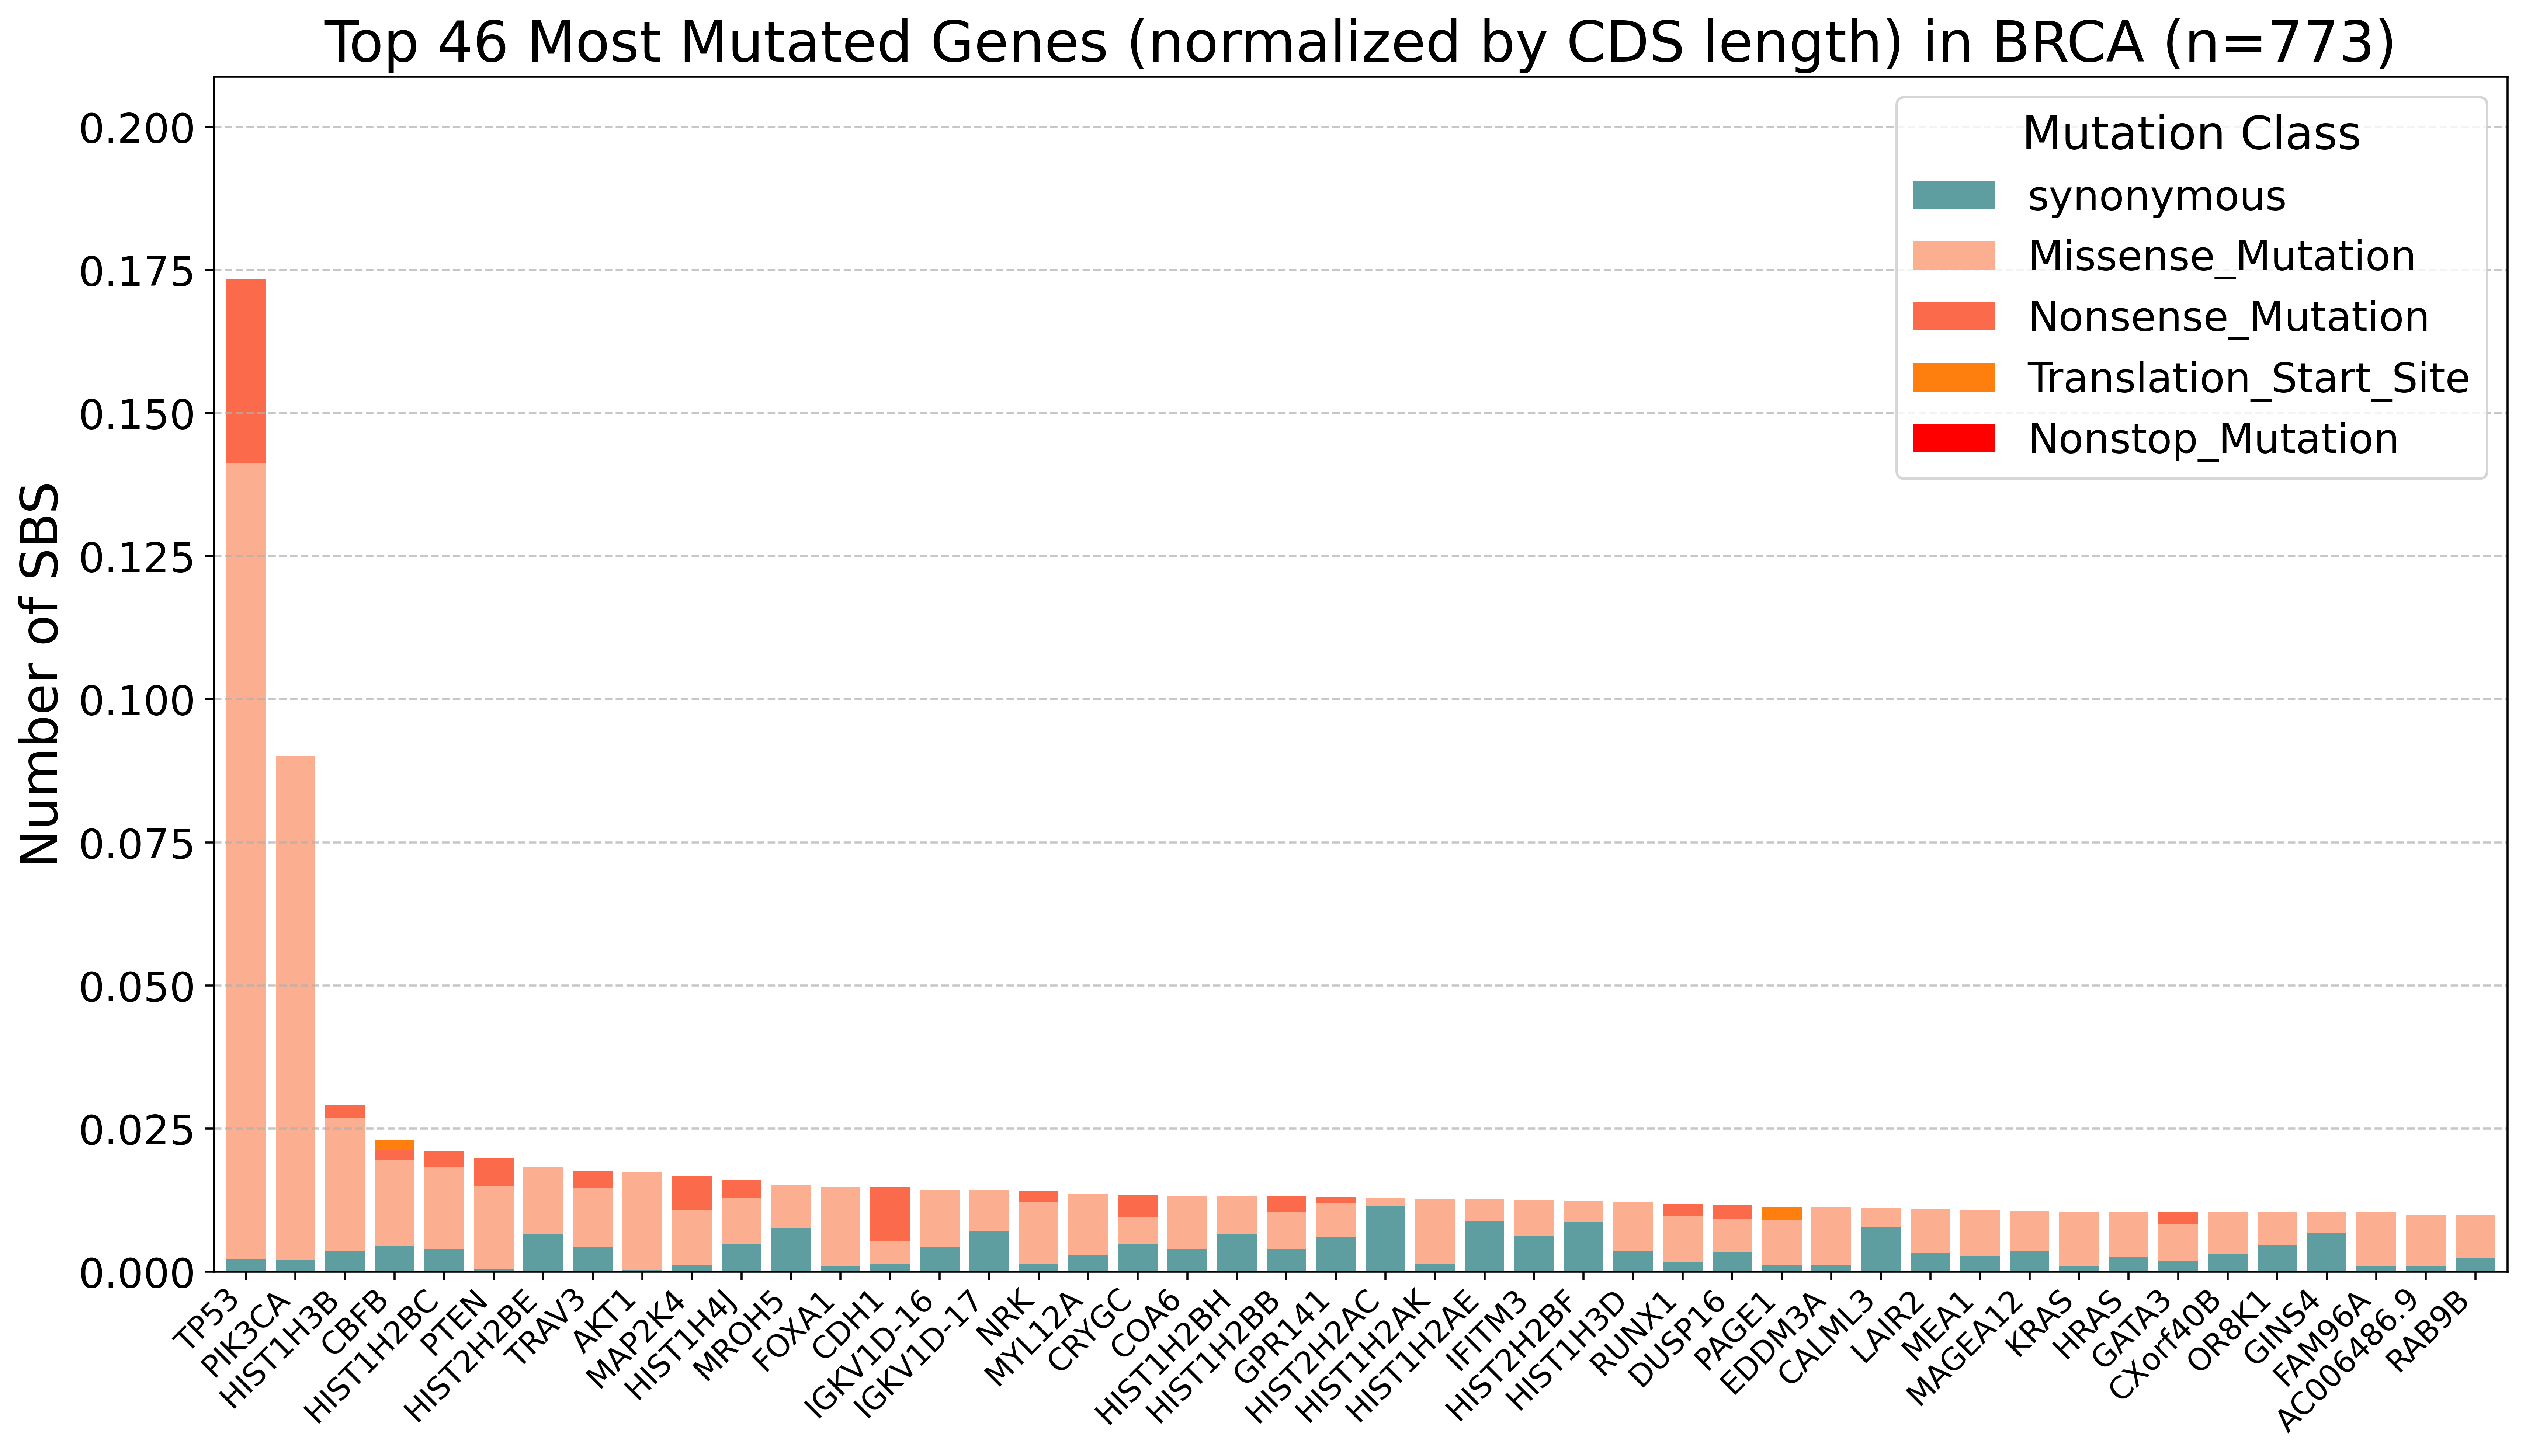

In [21]:
norm_df = counts_df[all_classes].div(counts_df['CDS_length'], axis=0).fillna(0)

# 8. Select top N genes by normalized total mutations
norm_df['Total'] = norm_df.sum(axis=1)
N = 46
plot_df = norm_df.sort_values('Total', ascending=False).head(N).drop(columns='Total')
top_46_genes_normalized_by_length = list(plot_df.index)

# 9. Define color palette
palette = ['cadetblue', '#fcae91', '#fb6a4a', "tab:orange",  # Translation_Start_Site
    "red"]  # Nonstop_Mutation

# 10. Plot
if plot_df.empty:
    print("No data available to plot after filtering for ≥5 mutations.")
else:
    print(", ".join(top_46_genes_normalized_by_length))
    print(len(set(top_46_genes_normalized_by_length)), "genes remaining after filtering")
    fig, ax = plt.subplots(
        figsize=(max(10, len(plot_df) * 0.3), 8),
        dpi=500
    )

    # Plot on this axis
    plot_df.plot(
        kind='bar',
        stacked=True,
        width=0.8,
        color=palette,
        ax=ax
    )

    # Labels and styling
    ax.set_title(f'Top {N} Most Mutated Genes (normalized by CDS length) in BRCA (n=773)', fontsize=22)
    
    ax.set_xlabel('', fontsize=18)
    ax.set_ylabel('Number of SBS', fontsize=20)
    ax.set_xticklabels(plot_df.index, rotation=45, fontsize=12, ha='right')
    ax.tick_params(axis='x', which='major', pad=1)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(title='Mutation Class', fontsize=16, title_fontsize=18)
    ax.grid(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylim(0, plot_df.max().max() * 1.5)



    plt.tight_layout()

    # Save at high resolution
    fig.savefig(
        "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/results/figures/Most_mutated_genes_detailed_normalized.pdf",
        format="pdf",
        bbox_inches="tight",
        dpi=500
    )

    plt.show()

# Number of possible nonsynonymous and synonymous mutations per codon in each gene's CDS

In [22]:
def translate(seq): 
       
    table = { 
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T', 
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                  
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P', 
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R', 
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A', 
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G', 
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L', 
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_', 
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W', 
    } 
    protein ="" 
    if len(seq)%3 == 0: 
        for i in range(0, len(seq), 3): 
            codon = seq[i:i + 3] 
            protein+= table[codon] 
    else:
        print("Error: Sequence length is not a multiple of 3.") 
        return None
    return protein 

In [23]:
df_sizes

Transcript_ID  CDS_start  CDS_end  CDS_length  \
Hugo_Symbol                                                     
A1BG          ENST00000263100         63     1550        1488   
A1CF          ENST00000373995        260     2044        1785   
A2M           ENST00000318602        309     4733        4425   
A2ML1         ENST00000299698        181     4545        4365   
A4GALT        ENST00000401850        491     1552        1062   
...                       ...        ...      ...         ...   
ZYG11B        ENST00000294353        146     2380        2235   
ZYX           ENST00000322764        346     2064        1719   
ZZEF1         ENST00000381638        126     9011        8886   
ZZZ3          ENST00000370801        477     3188        2712   
hsa-mir-1199  ENST00000269720          1     1086        1086   

                                                   CDS_sequence  
Hugo_Symbol                                                      
A1BG          ATGTCCATGCTCGTGGTCTTTCTCTTGCTGTGGGGTGTCACCTGGG...  
A1CF          ATGGAAGCAGTGTGTCTGGGCACATGCCCAGAGCCAGAAGCGAGCA...  
A2M           ATGGGGAAGAACAAACTCCTTCATCCAAGTCTGGTTCTTCTCCTCT...  
A2ML1         ATGTGGGCTCAGCTCCTTCTAGGAATGTTGGCCCTATCACCAGCCA...  
A4GALT        ATGTCCAAGCCCCCCGACCTCCTGCTGCGGCTGCTCCGGGGCGCCC...  
...                                                         ...  
ZYG11B        ATGCCCGAGGACCAGGCCGGCGCAGCCATGGAGGAGGCGTCTCCCT...  
ZYX           ATGGCGGCCCCCCGCCCGTCTCCCGCGATCTCCGTTTCGGTCTCGG...  
ZZEF1         ATGGGGAACGCTCCGAGTCACAGCAGTGAAGACGAAGCGGCAGCTG...  
ZZZ3          ATGGCTGCTTCCCGATCTACTCGTGTTACAAGATCAACAGTGGGGT...  
hsa-mir-1199  ATGGCCCCCCAGAGAGCGGGGCCGGGTCTAGGGAAGCCCTCTTCCA...  

[14486 rows x 5 columns]

# Calculate syn and nonsyn possible sites
Takes 4.5min

In [ ]:
bases = ['A', 'C', 'G', 'T']

syn_ops = []
nonsyn_ops = []

for gene, row in df_sizes.iterrows():
    seq = row["CDS_sequence"]
    
    # for each gene's CDS sequence
    if seq:
        if gene == "IGHJ5":
            print(f"Processing gene: {gene}")
            print(f"CDS sequence: {seq}")
            print(f"CDS length: {len(seq)}")
            print(range(0, len(seq) - 2, 3))
        
        # walk each codon in a gene and sum up fractions
        syn_fraction_sum = 0
        nonsyn_fraction_sum = 0
        for i in range(0, len(seq) - 3 + 1, 3):
            
            
            codon = seq[i:i+3]
            ref_aa = translate(codon)

            if gene == "IGHJ5":
                print(codon, "->", ref_aa)
            
            # for each site in a codon, count and divide by 3
            syn_fraction = 0
            nonsyn_fraction = 0
            syn_count = 0
            nonsyn_count = 0
            for pos in range(3):
                orig_base = codon[pos]
                for alt_base in bases:
                    if alt_base == orig_base:
                        continue
                    alt_codon = codon[:pos] + alt_base + codon[pos+1:]
                    aa = translate(alt_codon)
                    # Add at top of your script
                    bold_start = '\033[1m'
                    bold_end = '\033[0m'

                    # Then, inside your codon loop:
                    highlighted_codon = (
                        codon[:pos]
                        + bold_start + codon[pos] + bold_end
                        + codon[pos+1:]
                    )
                    highlighted_alt = (
                        alt_codon[:pos]
                        + bold_start + alt_codon[pos] + bold_end
                        + alt_codon[pos+1:]
                    )
                    if aa == ref_aa:
                        if gene == "IGHJ5":
                            print(f"{highlighted_codon}({ref_aa}) -> {highlighted_alt}({aa}) : S")
                        syn_count += 1 
                    else:
                        if gene == "IGHJ5":
                            print(f"{highlighted_codon}({ref_aa}) -> {highlighted_alt}({aa}) : N")
                        nonsyn_count += 1
            if gene == "IGHJ5":
                print(f"syn_count: {syn_count}/3, nonsyn_count: {nonsyn_count}/3")
            syn_fraction = syn_count / 3
            nonsyn_fraction = nonsyn_count / 3

            syn_fraction_sum += syn_fraction
            nonsyn_fraction_sum += nonsyn_fraction

    syn_ops.append(syn_fraction_sum)
    nonsyn_ops.append(nonsyn_fraction_sum)

df_sizes["synonymous_opportunity"] = syn_ops
df_sizes["nonsynonymous_opportunity"] = nonsyn_ops

Processing gene: IGHJ5
CDS sequence: AACTGGTTCGACCCCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG
CDS length: 49
range(0, 47, 3)
AAC -> N
AAC(N) -> CAC(H) : N
AAC(N) -> GAC(D) : N
AAC(N) -> TAC(Y) : N
AAC(N) -> ACC(T) : N
AAC(N) -> AGC(S) : N
AAC(N) -> ATC(I) : N
AAC(N) -> AAA(K) : N
AAC(N) -> AAG(K) : N
AAC(N) -> AAT(N) : S
syn_count: 1/3, nonsyn_count: 8/3
TGG -> W
TGG(W) -> AGG(R) : N
TGG(W) -> CGG(R) : N
TGG(W) -> GGG(G) : N
TGG(W) -> TAG(_) : N
TGG(W) -> TCG(S) : N
TGG(W) -> TTG(L) : N
TGG(W) -> TGA(_) : N
TGG(W) -> TGC(C) : N
TGG(W) -> TGT(C) : N
syn_count: 0/3, nonsyn_count: 9/3
TTC -> F
TTC(F) -> ATC(I) : N
TTC(F) -> CTC(L) : N
TTC(F) -> GTC(V) : N
TTC(F) -> TAC(Y) : N
TTC(F) -> TCC(S) : N
TTC(F) -> TGC(C) : N
TTC(F) -> TTA(L) : N
TTC(F) -> TTG(L) : N
TTC(F) -> TTT(F) : S
syn_count: 1/3, nonsyn_count: 8/3
GAC -> D
GAC(D) -> AAC(N) : N
GAC(D) -> CAC(H) : N
GAC(D) -> TAC(Y) : N
GAC(D) -> GCC(A) : N
GAC(D) -> GGC(G) : N
GAC(D) -> GTC(V) : N
GAC(D) -> GAA(E) : N
GAC(D) -> GAG(E) : N
GAC(D) ->

That is, if all potential mutations at a site cause nonsynonymous changes in both ORFs, it is an NN site, and so on. A site may belong to multiple categories and be called, for example, 1/3 NN site and 2/3 NS site, if one-third of potential mutations at the site cause nonsynonymous changes in both ORFs and two-thirds of potential mutations at the site cause nonsynonymous changes in ORF1 but synonymous changes in ORF2. [A Simple Method for Estimating the Strength of Natural Selection on Overlapping Genes](https://academic.oup.com/gbe/article/7/1/381/604609#:~:text=A%20site%20may,changes%20in%20ORF2.)

# Calculate dN/dS

In [ ]:
df_sizes.to_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.cds_length_sequence_syn_nonsyn_opportunities.tsv', index=True, sep="\t")

In [ ]:
df_sizes = pd.read_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/gencode.v23lift37.pc_transcripts.transcripts_in_TCGA_MAF.cds_length_sequence_syn_nonsyn_opportunities.tsv', sep="\t", index_col="Hugo_Symbol")
df_sizes

In [ ]:
counts_df

In [ ]:
len(set(counts_df.index.tolist()))

In [ ]:
# 1. Join observed counts with mutational opportunities
#    - counts_df: index=Hugo_Symbol, columns include 'synonymous', and various non-synonymous classes
#    - df_sizes: index=Hugo_Symbol, columns include 'synonymous_opportunity', 'nonsynonymous_opportunity'
df = counts_df.join(
    df_sizes[['synonymous_opportunity', 'nonsynonymous_opportunity', 'Transcript_ID', 'CDS_start', 'CDS_end', 'CDS_sequence']],
    how='inner'
)
df.to_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/real_mutation_count_with_cds_length_sequence_syn_nonsyn_opportunities.tsv', index=True, sep="\t")
df

# Warning! Some genes' transcripts or the gene name in somatic mutation MAF file simply don't exist in Gencode V23 GRCh37

CDH2 is in Gencode v47 GRCh37

In [ ]:
df = pd.read_csv('/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/real_mutation_count_with_cds_length_sequence_syn_nonsyn_opportunities.tsv', index_col="Hugo_Symbol", sep="\t")
df

In [ ]:
print(list(counts_df.index.difference(df.index)))
print(len(list(counts_df.index.difference(df.index))), "genes not in Gencode V27 GRCh37 CDS FASTA")

In [ ]:
intogen_genes = df_intogen_sorted['Symbol'].tolist()
print(intogen_genes)

In [ ]:
dnds_qallsubs_cv_significant = ["TP53",     "PIK3CA",   "HIST1H3B", "AKT1",     "PTEN",     "FOXA1",    "CBFB",     "MAP2K4",   "CASP8",    "RUNX1",    "ERBB2",    "GATA3",    "MAP3K1",   "CDH1",     "NCOR1",    "KMT2C",    "RB1",      "ARID1A",   "NF1"]

In [ ]:
for ele in list(counts_df.index.difference(df.index)):
    if ele in intogen_genes:
        print(ele, "in IntOGen")
    elif ele in dnds_qallsubs_cv_significant:
        print(ele, "in dNdScv")

In [ ]:
df_sizes.loc[["ABCG4"]]

In [ ]:
# 2. Compute observed nonsynonymous as sum of all non-synonymous classes
nonsyn_cols = [
    "Missense_Mutation",
    "Nonsense_Mutation",
    "Translation_Start_Site",
    "Nonstop_Mutation"
]
df['observed_nonsynonymous'] = df[nonsyn_cols].sum(axis=1)

# 3. Calculate dS = observed_synonymous / synonymous_opportunity
df['dS'] = df['synonymous'] / df['synonymous_opportunity']

# 4. Calculate dN = observed_nonsynonymous / nonsynonymous_opportunity
df['dN'] = df['observed_nonsynonymous'] / df['nonsynonymous_opportunity']

# 5. Calculate dN/dS ratio
df['dN/dS'] = df['dN'] / df['dS']

df

# Drop infinite (no observed synonymous) and NA (no observed nonsynonymous)

In [ ]:
inf_mask = df['dN/dS'] == np.inf
neg_inf_mask = df['dN/dS'] == -np.inf
nan_mask = pd.isna(df['dN/dS'])

unique_inf_indices = df.index[inf_mask].unique()
unique_neg_inf_indices = df.index[neg_inf_mask].unique()
unique_nan_indices = df.index[nan_mask].unique()

print(f"Number of unique index with np.inf in 'dN/dS': {len(unique_inf_indices)}")
print(f"Number of unique index with -np.inf in 'dN/dS': {len(unique_neg_inf_indices)}")
print(f"Number of unique index with np.nan in 'dN/dS': {len(unique_nan_indices)}")

In [ ]:
for ele in unique_inf_indices:
    if ele in intogen_genes:
        print(ele, "in IntOGen")
    elif ele in dnds_qallsubs_cv_significant:
        print(ele, "in dNdScv")

In [ ]:
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['dN/dS'])
print(f"Number of unique genes in 'dN/dS': {len(df.index.unique())}")

In [ ]:
df["expected S"] = df["synonymous"] * (df["nonsynonymous_opportunity"] / df["synonymous_opportunity"])
df["expected N"] = df["expected S"]
df["expected dS"] = df["expected S"] / df["synonymous_opportunity"]
df["expected dN"] = df["expected dS"]
df["expected dN/dS"] = df["expected dN"] / df["expected dS"]
df

In [ ]:
df.sort_values('dN/dS', ascending=False).head(30)

In [ ]:
df.to_csv(
    "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/data/processed/TCGA.BRCA.dN_dS.tsv",
    sep="\t",
    index=True,
    header=True
)
df

In [ ]:
# An example
df.loc[["TRIM9"]]

In [ ]:
df_sizes.loc[["TP53"]]["CDS_sequence"]

In [ ]:
# 1. Sort to get top 30 highest and top 10 lowest dN/dS
N = 46
df_high = df.sort_values('dN/dS', ascending=False).head(N)
df_low  = df.sort_values('dN/dS', ascending=True).head(10)

# 2. Combine into one DataFrame
df_plot = pd.concat([df_high, df_low])[['dN/dS']]
df_plot = df_plot.reset_index().rename(columns={'index': 'Hugo_Symbol'})

# 3. Prepare x positions, y values, and colors
x = np.arange(len(df_plot))
y = df_plot['dN/dS'].values
colors = ['firebrick'] * len(df_high) + ['steelblue'] * len(df_low)

# 4. Create lollipop plot
fig, ax = plt.subplots(figsize=(max(10, len(plot_df) * 0.3), 4), dpi=500)
for xi, yi, c in zip(x, y, colors):
    # Draw stem from baseline y=1 to the point
    ax.vlines(xi, 1, yi, color=c, linewidth=2)
# Draw dots on top of stems
ax.scatter(x, y, c=colors, s=30, zorder=3)

# 5. Baseline at y=1
ax.axhline(1, color='gray', linestyle='--', linewidth=1)

# 6. Adjust x-axis and reduce margins
plt.grid(axis='x', linestyle='--', alpha=0.7, linewidth=0.7, color="lightgray")
plt.grid(axis='y', linestyle='--', alpha=0.7, linewidth=0.7, color="lightgray")
plt.title('Top 30 Highest and Top 10 Lowest dN/dS Genes', fontsize=16)

# Build annotated x labels
ax.set_xlim(-1, len(df_plot))
ax.set_xticks(x)
ax.set_xticklabels(df_plot['Hugo_Symbol'], rotation=90, fontsize=12)

annot_labels = []
for gene in df_plot['Hugo_Symbol']:
    label = ""
    if gene in intogen_genes:
        label += '★'       # mark IntOGen drivers
    if gene in dnds_qallsubs_cv_significant:
        label += '▲'       # mark significant by dN/dS test
    label += gene
    
    annot_labels.append(label)
ax.set_xticklabels(annot_labels, rotation=45, fontsize=12, ha='right')
ax.tick_params(axis='x', which='major', pad=1)

# 7. Legend for annotation symbols
legend_elements = [
    Line2D([0], [0], marker='*', color='black', linestyle='None', markersize=8,
           label='Exist in IntOGen TCGA WES BRCA'),
    Line2D([0], [0], marker='^', color='black', linestyle='None', markersize=8,
           label='Exist in dNdScv traditional model')
]
ax.legend(handles=legend_elements, title='Annotations', fontsize=12,
          title_fontsize=14, loc='upper right')

# 8. Remove y=0 tick, add y=1, but leave out min_y on the left
ax.set_ylabel('dN/dS', fontsize=14)
min_y = y.min()
ax.set_ylim(min_y - 1, 60)

# Build left‐side ticks: drop 0 and min_y, only keep 1 and the rest
left_ticks = [t for t in ax.get_yticks() if t not in (0, min_y)]
left_ticks = sorted(set(left_ticks + [1.0]))
ax.set_yticks(left_ticks)
ax.set_yticklabels([f"{t:.0f}" for t in left_ticks], fontsize=12)
ax.set_ylim(min_y - 1, 60)

# 9. Create a twin axis just to draw the min_y tick on the right
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([min_y])
ax2.set_yticklabels([f"{min_y:.4f}"], fontsize=12)
ax2.yaxis.set_ticks_position('right')
ax2.tick_params(axis='y', length=4)  # adjust tick length if desired
ax2.set_ylim(min_y - 1, 60)

plt.tight_layout()

# 10. Save and show
output_path = "/Users/zichenjiang/Downloads/BENG 285 projects SP25/breast-cancer-team-1/project-2/results/figures/dNdS_lolliplot_top30_bottom10.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# 1. Sort by dN/dS and take top 30 genes
top30_genes = df.sort_values('dN/dS', ascending=False).head(N).index.tolist()
string=", ".join(top30_genes)
print("Top 30 genes by dN/dS:" , string)


# 2. Get IntOGen driver gene symbols
intogen_genes = df_intogen_sorted['Symbol'].tolist()

# 3. Convert to sets
set_top30 = set(top30_genes)
set_dnds_qallsubs_cv_significant = set(dnds_qallsubs_cv_significant)
set_intogen = set(intogen_genes)

# 4. Plot Venn diagram
plt.figure(figsize=(5, 5), dpi=500) # Adjusted figure size for 3 sets

# Create the Venn diagram - store the output to modify fonts
v = venn3([set_top30, set_dnds_qallsubs_cv_significant, set_intogen],
          set_labels=('Top 30 dN/dS', 'dNdScv traditional model', 'IntOGen Drivers'),
          set_colors=('skyblue', 'lightgreen', 'lightcoral'), # Optional: set colors
          alpha=0.7 # Optional: set transparency
         )